# Исследование объявлений о продаже квартир

В исследовании использованы данные Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Необходимо выработать автоматизированную систему определения рыночной стоимости объектов недвижимости и установить какие параметры на нее влияют.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

<b>Содержание:</b>
1. [Получение данных и изучение информации](#step1)
2. [Предобработка данных](#step2)
3. [Дополнительные расчеты и добавление данных в таблицу](#step3)
4. [Исследовательский анализ данных](#step4)
5. [Общий вывод](#step5)

### 1. Получение данных и изучение общей информации. 

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
from matplotlib.pyplot import figure
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15,8)
pd.options.mode.chained_assignment = None

In [2]:
df = pd.read_csv('/datasets/real_estate_data.csv', sep="\t")
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


### Вывод

В таблице 22 стоблца и 23699 строк. Имеющиеся типы данных  int, object, bool и float. Многие столбцы принадлежат к float, но по смыслу принадлежат к int. Также большинство столбцов содержит пропущенные значения, при это некоторые из них перекликаются по смыслу друг с другом. Рассмотрим это ниже более внимательно и примем решение заполнять ли эти ячейки данными и если да, то какими.

Видим, что в целом данные выгружены корректно, названия столбцов не содержат лишних пробелов, все в одном регистре, а также корректно отображают смысл содержания столбца, а значит доработки не требуют. Также нет отрицательных значений в столбцах, где их и не может быть по смыслу. В некоторых столбцах заметны аномальные диапазоны значений, проаналилируем эту информацию ниже.

### 2. Предобработка данных

Посмотрим на таблицу глазами.

In [3]:
df.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,...,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,...,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,...,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,...,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,...,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,...,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,...,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,...,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,...,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


Поменяем порядок столбцов для большей наглядности таблицы

In [4]:
df.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

In [5]:
df = df[['last_price', 'total_area', 'living_area', 'kitchen_area', 'first_day_exposition', 'days_exposition',
       'rooms', 'ceiling_height', 'balcony', 'studio', 'open_plan',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest',  'total_images', 'is_apartment', 'floors_total', 'floor']]

Для определения пропусков построим тепловую карту.

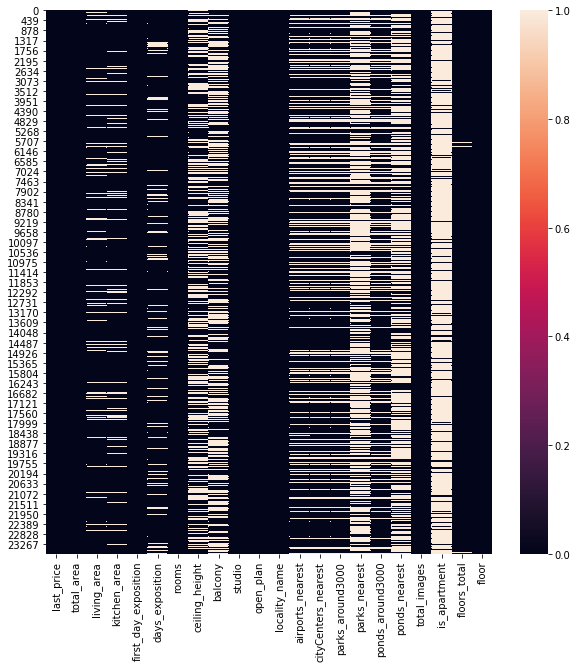

In [6]:
plt.figure(figsize=(10,10))
sns.heatmap(df.isnull()).set_title;

In [7]:
#df['days_exposition'].isnull().count()
#df.dropna(subset = ['days_exposition'], inplace = True)
#df.info()

Пропуски в столбце "апартаменты" означают, что это жилая квартира, а не апартаменты, их логично заполнить значениями False, т.к. столбец типа булеан. Также строки со значением True нужно удалить из таблицы, как не целевые, поскольку это не квартиры.

Пропуски в разделе "балкон" означают, что балкона нет, поэтому заполним нулями.

Пропуски в "жилой площади" и "площадь кухни" коррелируют друг с другом, это скорее всего квартиры со свободной планировкой, возможно без ремонта. При этом в "общей площади" пропусков нет, поэтому рассчитаем и заполним их средними значениями, пропорционально другим объектам, где эти данные заполнены, предварительно сгруппировав по площади.

По такому же принципу заполним высоту потолка - сгруппируем данные по площади и посчитаем средние значения, предварительно удалив строки с некорректными значениями высоты потолка - все, что ниже 2.4 метров и выше 5 будем считать выбросами, поскольку их количество невелико, и даже если они действительно существуют, то их нужно рассматривать как отдельную категорию, а в нашей статистике они могут исказить результат. Есть несколько значений с высотой потолка 27-32 метра, здесь очень вероятно имелись ввиду данные 2.7-3.2 метра, однако таких значений всего около 8 штук, проще избавиться от таких строк, поскольку у нас суммарно более 23тыс.строк.

Пропуски в последних 7 столбцах также коррелируют друг с другом. Их заполним медианными значениями, предварительно сгруппированых по локации объектов, где эти данные указаны.

Строки с пропущенным значением суммарного количества этажей удалим. Их можно было бы заполнить по столбцу "этаж", просто скопировав это значение, тогда квартира бы статистически находилась на последнем этаже, а это отдельный параметр влияющий на цену. Либо заполнить медианой или средним,но таких строк менее 100, поэтому для чистоты эксперимента лучше удалить. Также удалим строки, где этажность более 37 этажей, т.к. таких домов в Питере нет. Количество этих значений несущественно по сравнению с общим числом строк.

Также из сводной таблицы видно, что есть квартиры площадью от 12 метров. Скорее всего это комнаты, ошибочно помеченные как квартиры, т.к. площадь очень маленькая для квартиры. Поэтому такого типа строки тоже нужно удалить. Возьмем за нижнюю границу 20 метров квадратных. 

Также удалим из таблицы квартиры площадью более 300 м.кв. поскольку это отдельный тип элитной недвижимости (скорее всего из той же категории, где очень высокий потолок), цены на которую живут по своим законам и их нужно исследовать отдельно. При другой постановке исходной задачи их можно было бы выделить в отдельный класс и провести детальное исследование. 

In [8]:
df.columns

Index(['last_price', 'total_area', 'living_area', 'kitchen_area',
       'first_day_exposition', 'days_exposition', 'rooms', 'ceiling_height',
       'balcony', 'studio', 'open_plan', 'locality_name', 'airports_nearest',
       'cityCenters_nearest', 'parks_around3000', 'parks_nearest',
       'ponds_around3000', 'ponds_nearest', 'total_images', 'is_apartment',
       'floors_total', 'floor'],
      dtype='object')

In [9]:
#удалим апартаменты из списка
df=df[df['is_apartment'] != True]
df['is_apartment'] = df['is_apartment'].fillna(False)
print(df['is_apartment'].value_counts(dropna = False ))

False    23649
Name: is_apartment, dtype: int64


In [10]:
#удалим квартиры, где не указано количество этажей, т.к их всего 5 в таблице
#также удалим строки, где этажность более 37 этажей
df['floors_total'] = df['floors_total'].fillna(0)
df = df[df['floors_total']!=0]
df = df[df['floors_total'] <= 37]
df.shape

(23561, 22)

In [11]:
#удалим квартиры площадью менее 20 метров и более 400
df = df.query('300 >= total_area >= 20')
df.shape

(23474, 22)

In [12]:
#удалим объекты, где не указана локация
df.dropna(subset =['locality_name'], inplace=True)#(how='any',axis=0)
df.shape

(23426, 22)

In [13]:
#заполним пропуски в балконах нулями
df['balcony'] = df['balcony'].fillna(0)

<div class="alert alert-block alert-warning">
<h2>Комментарий от ревьювера (принимаем к размышлению)</h2> 

Хардкорненько)
</div>

In [17]:
#заполним пропуски в высоте потолка, жилой площади и кухни средними значениями в каждой группе площадей
def fillna_total(column, column2):
    df.loc[df[column].isnull(), column] = df.groupby(column2)[column].transform('median')
    df[column] = df[column].fillna(df[column].median())
#fillna_total('ceiling_height')
fillna_total('kitchen_area', 'total_area')
fillna_total('living_area','total_area')
fillna_total('airports_nearest', 'locality_name')
fillna_total('cityCenters_nearest', 'locality_name')
fillna_total('parks_around3000', 'locality_name')
fillna_total('parks_nearest', 'locality_name')
fillna_total('ponds_around3000', 'locality_name')
fillna_total('ponds_nearest', 'locality_name')
fillna_total('ceiling_height', 'locality_name')
fillna_total('days_exposition', 'locality_name')

Проверим как отразились проведенные преобразования на данных

In [18]:
df.describe()

,last_price,total_area,living_area,kitchen_area,days_exposition,rooms,ceiling_height,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,total_images,floors_total,floor
count,2.342600e+04,23426.000000,23426.000000,23426.000000,23426.000000,23426.000000,23426.000000,23426.000000,23426.000000,23426.000000,23426.000000,23426.000000,23426.000000,23426.000000,23426.000000,23426.000000,23426.000000
mean,6.297770e+06,59.438859,34.038082,10.368730,169.789465,2.060787,2.725694,0.593400,28320.827755,13956.433642,0.466405,472.681145,0.820669,509.344446,9.875224,10.694869,5.886451
std,7.769491e+06,30.460000,19.692102,5.490518,206.413815,1.044852,0.761555,0.958969,11094.497459,7552.260522,0.745590,202.987169,0.825672,174.629184,5.676856,6.584069,4.874458
min,1.219000e+04,20.000000,2.000000,1.300000,1.000000,0.000000,1.000000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,0.000000,1.000000,1.000000
25%,3.400000e+06,40.000000,18.700000,7.000000,45.000000,1.000000,2.550000,0.000000,21120.000000,10972.250000,0.000000,461.000000,0.000000,504.000000,6.000000,5.000000,2.000000
50%,4.600000e+06,52.000000,30.000000,9.000000,95.000000,2.000000,2.700000,0.000000,26768.000000,13094.000000,0.000000,461.000000,1.000000,504.000000,9.000000,9.000000,4.000000
75%,6.750000e+06,69.200000,42.000000,11.700000,200.000000,3.000000,2.700000,1.000000,34324.000000,15247.000000,1.000000,461.000000,1.000000,504.000000,14.000000,16.000000,8.000000
max,3.300000e+08,300.000000,250.000000,107.000000,1580.000000,16.000000,32.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,50.000000,37.000000,33.000000


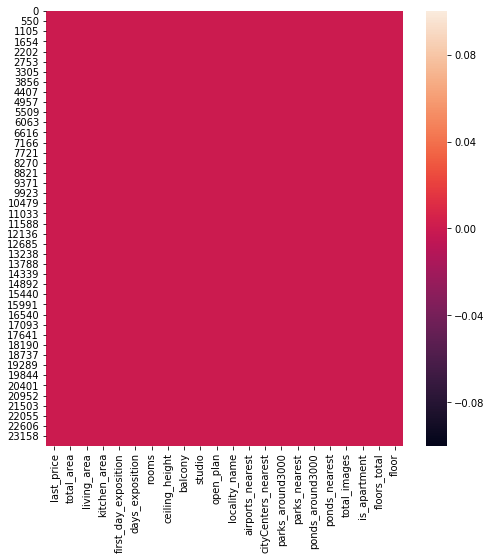

In [19]:
plt.figure(figsize=(8,8))
sns.heatmap(df.isnull()).set_title;

Пропусков не осталось. Также из сводной таблицы видно, что минимальные и максимальные значения данных выглядят правдоподобно.

Теперь избавимся от некорректных значений в столбце с высотой потолка, а также поменяем типы данных. Для этого вызовем метод info. Также удалим дубликаты. Типы данных будем менять исходя из логики, в тех столбцах где единицы измерения подразумеваются целочисленные, такие как например количество комнат, цена и тд. Столбец с датой также приведем к новому типу- дата.

In [20]:
df = df.query('2.4 <= ceiling_height <= 6')

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23375 entries, 0 to 23698
Data columns (total 22 columns):
last_price              23375 non-null float64
total_area              23375 non-null float64
living_area             23375 non-null float64
kitchen_area            23375 non-null float64
first_day_exposition    23375 non-null object
days_exposition         23375 non-null float64
rooms                   23375 non-null int64
ceiling_height          23375 non-null float64
balcony                 23375 non-null float64
studio                  23375 non-null bool
open_plan               23375 non-null bool
locality_name           23375 non-null object
airports_nearest        23375 non-null float64
cityCenters_nearest     23375 non-null float64
parks_around3000        23375 non-null float64
parks_nearest           23375 non-null float64
ponds_around3000        23375 non-null float64
ponds_nearest           23375 non-null float64
total_images            23375 non-null int64
is_apartme

In [22]:
#меняем типы данных, изменяем столбец с датой

def change_type(column, col_type):
    df[column]= df[column].astype(col_type)
    
change_type('last_price', 'int')
change_type('days_exposition', 'int')
change_type('rooms', 'int')
change_type('balcony', 'int')
change_type('floors_total', 'int')

df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23375 entries, 0 to 23698
Data columns (total 22 columns):
last_price              23375 non-null int64
total_area              23375 non-null float64
living_area             23375 non-null float64
kitchen_area            23375 non-null float64
first_day_exposition    23375 non-null datetime64[ns]
days_exposition         23375 non-null int64
rooms                   23375 non-null int64
ceiling_height          23375 non-null float64
balcony                 23375 non-null int64
studio                  23375 non-null bool
open_plan               23375 non-null bool
locality_name           23375 non-null object
airports_nearest        23375 non-null float64
cityCenters_nearest     23375 non-null float64
parks_around3000        23375 non-null float64
parks_nearest           23375 non-null float64
ponds_around3000        23375 non-null float64
ponds_nearest           23375 non-null float64
total_images            23375 non-null int64
is_apart

Проверим как выглядят данные.

In [24]:
df.head()

,last_price,total_area,living_area,kitchen_area,first_day_exposition,days_exposition,rooms,ceiling_height,balcony,studio,...,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,total_images,is_apartment,floors_total,floor
0,13000000,108.0,51.0,25.0,2019-03-07,95,3,2.70,0,False,...,18863.0,16028.0,1.0,482.0,2.0,755.0,20,False,16,8
1,3350000,40.4,18.6,11.0,2018-12-04,81,1,2.60,2,False,...,12817.0,18603.0,0.0,461.0,0.0,584.5,7,False,11,1
2,5196000,56.0,34.3,8.3,2015-08-20,558,2,2.70,0,False,...,21741.0,13933.0,1.0,90.0,2.0,574.0,10,False,5,4
3,64900000,159.0,95.0,15.0,2015-07-24,424,3,2.70,0,False,...,28098.0,6800.0,2.0,84.0,3.0,234.0,0,False,14,9
4,10000000,100.0,32.0,41.0,2018-06-19,121,2,3.03,0,False,...,31856.0,8098.0,2.0,112.0,1.0,48.0,2,False,14,13


Теперь можно удалить дубликаты, если они есть

In [25]:
df= df.drop_duplicates().reset_index(drop = True)
df.shape

(23375, 22)

### Вывод:

Данные готовы для дальнейшего анализа.

### 3. Дополнительные расчеты и добавление данных в таблицу

Расчитаем и добавим в таблицу данные для дальнейшего анализа:

- цену квадратного метра;
- день недели, месяц и год публикации объявления;
- этаж квартиры; варианты — первый, последний, другой;
- соотношение жилой и общей площади, а также отношение площади кухни к общей.

In [26]:
#цена квадратного метра - отношение цены к площади
df['meter_price'] = df['last_price']/df['total_area']
change_type('meter_price', 'int')

#день недели, месяц и год публикации объявления
#df['weekday'] = df['first_day_exposition'].df.dayofweek
df['weekday'] = pd.DatetimeIndex(df['first_day_exposition']).weekday_name
df['weekday_num'] = pd.DatetimeIndex(df['first_day_exposition']).weekday
df['day'] = pd.DatetimeIndex(df['first_day_exposition']).day
df['month'] = pd.DatetimeIndex(df['first_day_exposition']).month
df['year'] = pd.DatetimeIndex(df['first_day_exposition']).year

#этаж квартиры; варианты — первый, последний, другой
df['floor_type']='other'
for index, row in df.iterrows():
    if row['floor'] == row['floors_total']:
        df['floor_type'][index] = 'last'
    elif row['floor'] == 1:
        df['floor_type'][index] = 'first'
#    else:
#        df['floor_type'][index] = 'other'
        
#соотношение жилой и общей площади
df['life_to_com'] = df['living_area']/df['total_area']
#col_round('life_to_com', 3)

#отношение площади кухни к общей
df['kitchen_to_com'] = df['kitchen_area']/df['total_area']

df.head()

,last_price,total_area,living_area,kitchen_area,first_day_exposition,days_exposition,rooms,ceiling_height,balcony,studio,...,floor,meter_price,weekday,weekday_num,day,month,year,floor_type,life_to_com,kitchen_to_com
0,13000000,108.0,51.0,25.0,2019-03-07,95,3,2.70,0,False,...,8,120370,Thursday,3,7,3,2019,other,0.472222,0.231481
1,3350000,40.4,18.6,11.0,2018-12-04,81,1,2.60,2,False,...,1,82920,Tuesday,1,4,12,2018,first,0.460396,0.272277
2,5196000,56.0,34.3,8.3,2015-08-20,558,2,2.70,0,False,...,4,92785,Thursday,3,20,8,2015,other,0.612500,0.148214
3,64900000,159.0,95.0,15.0,2015-07-24,424,3,2.70,0,False,...,9,408176,Friday,4,24,7,2015,other,0.597484,0.094340
4,10000000,100.0,32.0,41.0,2018-06-19,121,2,3.03,0,False,...,13,100000,Tuesday,1,19,6,2018,other,0.320000,0.410000


### Вывод:

Необходимые данные рассчитаны и столбцы успешно добавлены.

### 4. Исследовательский анализ данных:

Пункт 1.

Изучим следующие параметры: площадь, цена, число комнат, высота потолков. Построим гистограммы для каждого параметра.

In [27]:
def histogram(col1, title, x, y):
    df.hist(col1, bins = 100, figsize=(10,5), density = 1);
    plt.title(title);
    plt.xlabel(x);
    plt.ylabel(y);

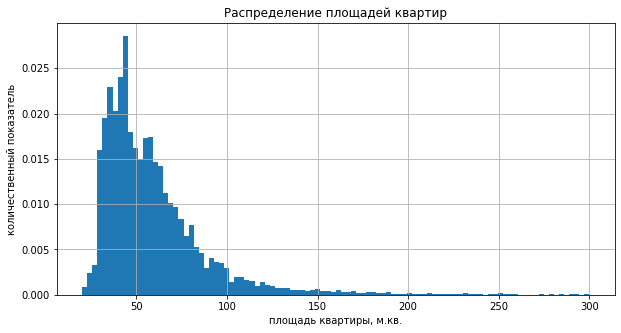

In [28]:
histogram('total_area',"Распределение площадей квартир", "площадь квартиры, м.кв.", "количественный показатель")

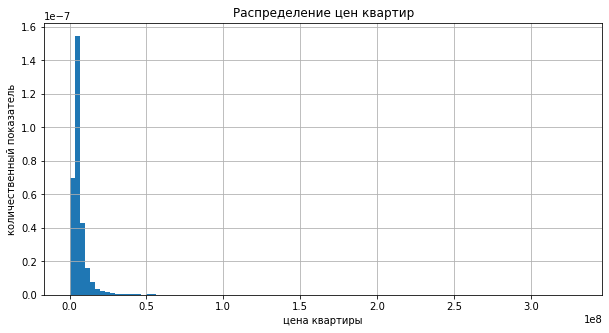

In [29]:
histogram('last_price',"Распределение цен квартир", "цена квартиры", "количественный показатель")

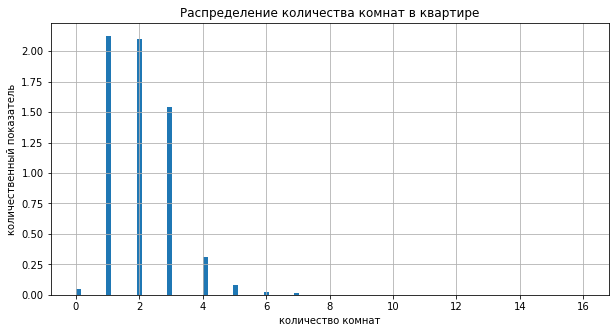

In [30]:
histogram('rooms',"Распределение количества комнат в квартире", "количество комнат", "количественный показатель")

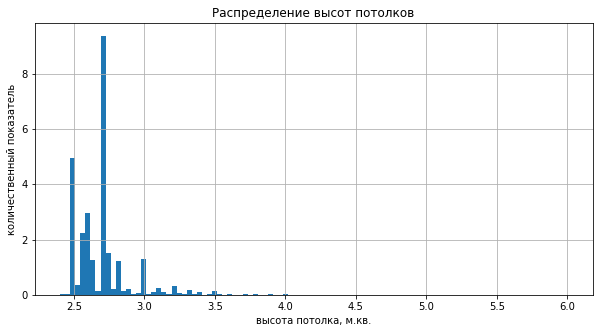

In [31]:
histogram('ceiling_height',"Распределение высот потолков", "высота потолка, м.кв.", "количественный показатель")

Изучим время продажи квартиры. 
Построим гистограмму, посчитаем среднее и медиану и сделаем вывод. 

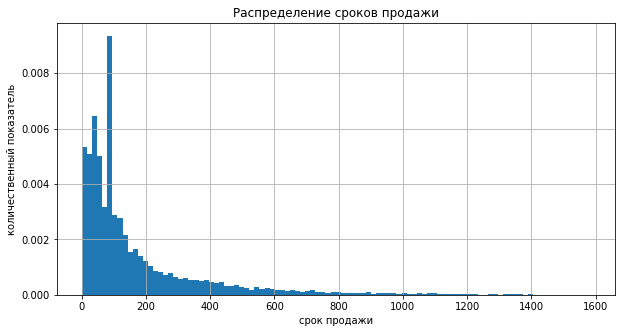

In [32]:
histogram('days_exposition',"Распределение сроков продажи", "срок продажи", "количественный показатель")

In [33]:
df['days_exposition'].describe()

count    23375.000000
mean       169.825241
std        206.529944
min          1.000000
25%         45.000000
50%         95.000000
75%        200.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [34]:
annormal = df.query("0 < days_exposition < 200")
annormal['days_exposition'].value_counts().head()

95    2190
45     917
60     543
7      231
90     229
Name: days_exposition, dtype: int64

**Вывод 1:**

Исходя из данных можно сделать вывод, что половина квартир продается в первые 3-4 месяца после публикации, это можно считать обычным сроком продажи. 3/4 квартир продаются в течении 7-8 месяцев. Из графика можно сказать, что продажи более полутора лет можно считать аномально долгими, а продажи в течении месяца очень быстрыми.

Есть три выброса: 182, 45 и 60 дней, с чем это связано рассмотрим подробнее ниже. Есть предположение, что это влияние квартир, которые можно отнести к элитной недвижимости, может искажать статистику, тк. такие объекты могут продаваться аномально долго и влиять на статистику.

In [35]:
annormal_max = df.query("days_exposition == 182")
annormal_max.describe()

,last_price,total_area,living_area,kitchen_area,days_exposition,rooms,ceiling_height,balcony,airports_nearest,cityCenters_nearest,...,total_images,floors_total,floor,meter_price,weekday_num,day,month,year,life_to_com,kitchen_to_com
count,3.700000e+01,37.000000,37.000000,37.000000,37.0,37.000000,37.000000,37.000000,37.000000,37.000000,...,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000
mean,5.580716e+06,59.689189,35.603514,9.674595,182.0,2.189189,2.685135,0.594595,25995.621622,11595.675676,...,11.081081,9.081081,5.297297,91199.810811,2.945946,16.729730,6.324324,2017.108108,0.585553,0.178702
std,4.151777e+06,25.129098,16.919159,3.490288,0.0,0.938019,0.143790,0.956250,7015.784079,4734.598259,...,5.861259,5.712454,4.248299,41074.564587,1.914070,8.542861,3.333784,0.906268,0.112296,0.079662
min,1.200000e+06,32.000000,13.500000,5.500000,182.0,1.000000,2.500000,0.000000,7900.000000,1257.000000,...,0.000000,4.000000,1.000000,20967.000000,0.000000,1.000000,1.000000,2015.000000,0.311715,0.079470
25%,2.950000e+06,44.000000,23.400000,7.000000,182.0,1.000000,2.550000,0.000000,24319.000000,9734.000000,...,7.000000,5.000000,2.000000,62073.000000,2.000000,10.000000,3.000000,2017.000000,0.527778,0.131737
50%,4.550000e+06,54.000000,31.000000,8.800000,182.0,2.000000,2.700000,0.000000,26768.000000,13094.000000,...,10.000000,7.000000,4.000000,90625.000000,3.000000,18.000000,7.000000,2017.000000,0.581395,0.149351
75%,6.529500e+06,66.800000,47.000000,11.110000,182.0,3.000000,2.700000,1.000000,26768.000000,13094.000000,...,17.000000,10.000000,7.000000,111898.000000,4.000000,24.000000,9.000000,2018.000000,0.663029,0.222987
max,2.100000e+07,133.000000,77.350000,18.000000,182.0,4.000000,3.000000,4.000000,43074.000000,28233.000000,...,20.000000,25.000000,17.000000,194560.000000,6.000000,28.000000,12.000000,2018.000000,0.838710,0.406321


Видим 11-комнатный объект. Удалим квартиры с номально большим количством комнат и площадью более 200 метров и посмотрим на результат.

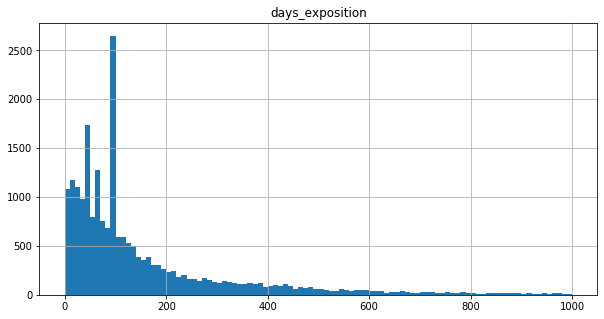

In [36]:
df = df.query("rooms <4 & total_area < 200")
df.hist('days_exposition',  range=(0,1000), bins = 100, figsize=(10,5));

Выброс не исчез. 

**Вывод 2:**

Была выдвинута версия, что это связано с некорректным заполнением пропущенных значений в начальной таблице. Версия прошла проверку в ячейке №6. Если раскомментировать эти строки, то выброс исчезнет, однако общий характер диаграммы не изменится. Значит для анализа по этому столбцу пропуски было лучше удалить. Однако при этом потеряется более 2 тысяч строк, а это около 10% данных, которые пригодны для анализа по другим характеристикам. По этой причине оставим данные как есть.

Пункт 2.

Проверим какие из факторов больше всего влияют на стоимость квартиры:

- площадь, число комнат, удалённость от центра,
- этаж: первый, последний или другой
- дата размещения: днь недели, месяц и год.

In [37]:
df.columns

Index(['last_price', 'total_area', 'living_area', 'kitchen_area',
       'first_day_exposition', 'days_exposition', 'rooms', 'ceiling_height',
       'balcony', 'studio', 'open_plan', 'locality_name', 'airports_nearest',
       'cityCenters_nearest', 'parks_around3000', 'parks_nearest',
       'ponds_around3000', 'ponds_nearest', 'total_images', 'is_apartment',
       'floors_total', 'floor', 'meter_price', 'weekday', 'weekday_num', 'day',
       'month', 'year', 'floor_type', 'life_to_com', 'kitchen_to_com'],
      dtype='object')

In [38]:
def corelation(col1, col2):
    print('корреляция', col1, ': ', df[col1].corr(df[col2]))

corelation('total_area','last_price')
corelation('rooms','last_price')
corelation('cityCenters_nearest','last_price')
print('----------------------------')
corelation('weekday_num','last_price')
corelation('month','last_price')
corelation('year','last_price')

корреляция total_area :  0.6223420972896064
корреляция rooms :  0.2995356292740407
корреляция cityCenters_nearest :  -0.2109135380186622
----------------------------
корреляция weekday_num :  -0.011691875242909006
корреляция month :  0.0023662110782335655
корреляция year :  -0.01653431459437479


In [39]:
def diagram(temp1, temp2, title, xlab, ylab):
    df.plot(x=temp1, y=temp2, kind='scatter', alpha=0.1, figsize=(10, 5));
    plt.title(title);
    plt.xlabel(xlab);
    plt.ylabel(ylab);

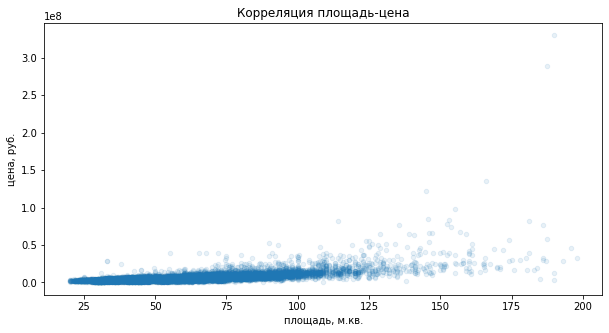

In [40]:
diagram('total_area', 'last_price', "Корреляция площадь-цена", "площадь, м.кв.", "цена, руб.");

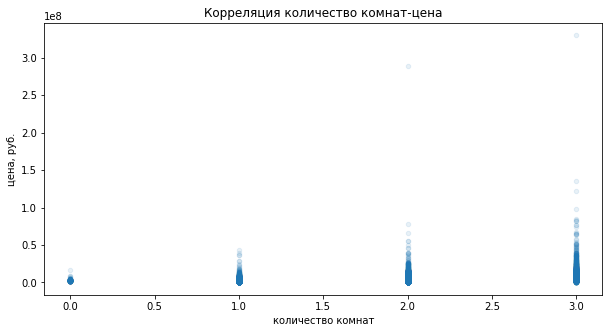

In [41]:
diagram('rooms', 'last_price', "Корреляция количество комнат-цена", "количество комнат", "цена, руб.");

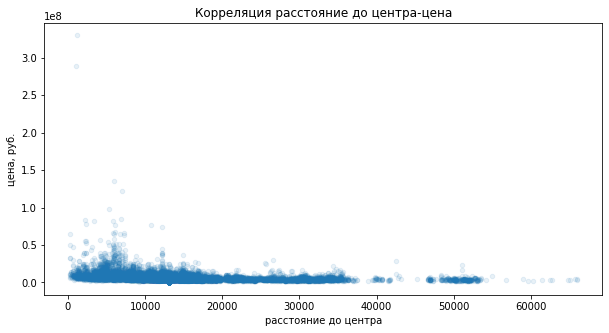

In [42]:
diagram('cityCenters_nearest', 'last_price', "Корреляция расстояние до центра-цена", "расстояние до центра", "цена, руб.");

Из расчетов и графиков можно сделать одинаковые выводы, поскольку они дают одинаковый результат:

Коэффициенты корреляции во всех случаях, кроме суммарной площади квартиры близки к нулю.

Это говорит о том, что связи с днем, месяцем и годом нет, неважно когда именно было размещенио объявление, если речь идет о недвижимости. И это логично, ведь это не горячие пирожки, а фундаментальная, дорогостоящая покупка, которую люди обычно выбирают долго.

Количество комнат влияет на цену, поскольку обычно с увеличением их количества растет и площадь. 

Близость к центру влияет чуть больше, чем время размещения, однако связь нелинейная, а значит влияние не очень выраженное. 

Из перечисленных показателей самое выраженное влияние оказывает площадь квартиры и количество комнат, здесь зависимоть почти линейная. И это что логично, поскольку цена рассчитывается исходя из квадратных метров. 

In [43]:
df_floor0 = df.groupby('floor_type').sum()[['meter_price']]
df_floor1 = df.groupby('floor_type').count()[['meter_price']]
df_floor = df_floor0['meter_price'] /df_floor1['meter_price'] #len(df.groupby('floor_type')
df_floor

floor_type
first     81707.777820
last      88437.033887
other    102184.602623
Name: meter_price, dtype: float64

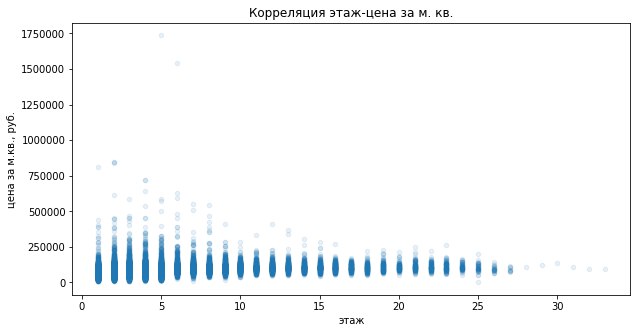

In [44]:
diagram('floor', 'meter_price', "Корреляция этаж-цена за м. кв.", "этаж", "цена за м.кв., руб.");

Здесь необходимо совместить два вывода:

С одной стороны при расчете корреляции видно, что самый дорогой квадратный метр на этажах в середине дома, самый дешевый первый - а именно, примерно на 20% дешевле. Цены на последних этажах несколько выше, чем на первых, но уступают ценам в середине примерно на 10%.

С другой стороны, из графика видно, что стоимость первого-второго этажа немного ниже, чем в середине здания, а к последний этажам она уменьшается.

Предполагаю, что некорорый перекос получился из-за того, что на графике смешаны этажи в середине здания и последние этажи. Т.е. не видно, что этаж являлся последним. Поэтому в данном случае логичнее доверять коэфиициенту корреляции.

Пункт 3. 

Выберем 10 населённых пунктов с наибольшим числом объявлений. Посчитаем среднюю цену квадратного метра в этих населённых пунктах. Выделим среди них населённые пункты с самой высокой и низкой стоимостью жилья.

In [46]:
max_adv_10 = df['locality_name'].value_counts().sort_values(ascending=False).head(10)
mean_meter_10 = df.query('locality_name in @max_adv_10.index').groupby('locality_name')['meter_price'].mean().sort_values(ascending=False).reset_index()
mean_meter_10

,locality_name,meter_price
0,Санкт-Петербург,113310.249965
1,Пушкин,102994.801153
2,деревня Кудрово,92473.086957
3,посёлок Парголово,90494.157407
4,посёлок Мурино,85782.264078
5,посёлок Шушары,78602.348131
6,Колпино,75898.396166
7,Всеволожск,68990.615584
8,Гатчина,68496.986667
9,Выборг,58102.500000


In [47]:
print('Населённый пункт с самой высокой стоимостью жилья:\t ', mean_meter_10['locality_name'][0])
print(' ')
print('Населённый пункт с самой низкой стоимостью жилья:\t',mean_meter_10['locality_name'][9])

Населённый пункт с самой высокой стоимостью жилья:	  Санкт-Петербург
 
Населённый пункт с самой низкой стоимостью жилья:	 Выборг


Пункт 4. 

Выделим квартиры в Санкт-Петербурге и выясним, какая область входит в центр. Создадим столбец с расстоянием до центра в километрах и округли до целых значений. Посчитаем среднюю цену для каждого километра. Построим график, который покажет как цена зависит от удалённости от центра. Определим центральную зону.

In [48]:
df_spb=df[df['locality_name'] == 'Санкт-Петербург']
#df_spb.head()

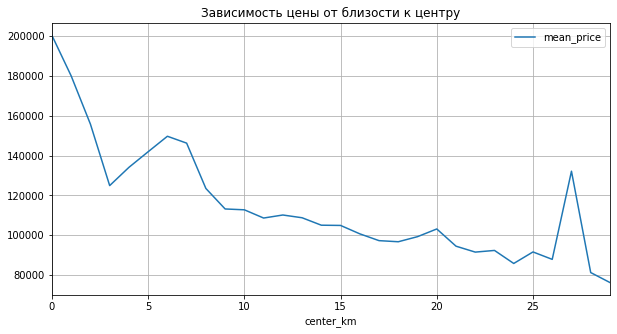

In [49]:
# Расстояние до центра к километрах:
df_spb['center_km'] = round(df_spb['cityCenters_nearest'] / 1000, 0) 

# Средняя цена для каждого километра:
spb_price = df_spb.pivot_table(index = 'center_km', values = 'meter_price')
spb_price.columns = ['mean_price']

# Зависимость цены от близости к центру
spb_price.plot(title='Зависимость цены от близости к центру', grid=True, figsize=(10, 5));

Вывод:

Исходя из графика, радиус "центра города" составляет приблизительно 7 км.

Пункт 5.

Выделим сегмент квартир в центре. Проанализируум и изучим следующие параметры: площадь, цена, число комнат, высота потолков. Также выделим факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления).

In [50]:
df_spb = df_spb[df_spb['center_km'] <=7]

In [51]:
def corelation_center(col1, col2):
    print('корреляция', col1, ': ', df_spb[col1].corr(df_spb[col2]))

corelation_center('total_area','last_price')
corelation_center('ceiling_height','last_price')
corelation_center('rooms','last_price')
corelation_center('floor','last_price')
corelation_center('day','last_price')
corelation_center('month','last_price')
corelation_center('year','last_price')
corelation_center('center_km','last_price')

корреляция total_area :  0.570822838023247
корреляция ceiling_height :  0.13865273429301345
корреляция rooms :  0.22943784939254241
корреляция floor :  0.09433149666148428
корреляция day :  0.022985073882737826
корреляция month :  -0.019890741471071244
корреляция year :  -0.001689150278285086
корреляция center_km :  -0.028620305529806205


In [52]:
df.describe()

,last_price,total_area,living_area,kitchen_area,days_exposition,rooms,ceiling_height,balcony,airports_nearest,cityCenters_nearest,...,total_images,floors_total,floor,meter_price,weekday_num,day,month,year,life_to_com,kitchen_to_com
count,2.173100e+04,21731.000000,21731.000000,21731.000000,21731.000000,21731.000000,21731.000000,21731.000000,21731.000000,21731.000000,...,21731.000000,21731.000000,21731.000000,2.173100e+04,21731.000000,21731.000000,21731.000000,21731.000000,21731.000000,21731.000000
mean,5.565745e+06,54.569261,30.753775,10.021411,165.335465,1.881460,2.688094,0.603792,28469.267958,14276.276909,...,9.805255,10.930284,5.995444,9.779936e+04,2.568405,15.483135,6.399705,2017.386314,0.559198,0.192598
std,5.511098e+06,21.241866,13.499107,4.890055,201.519450,0.806001,0.198331,0.955635,11218.890649,7423.904079,...,5.613154,6.652278,4.938930,4.411308e+04,1.790694,8.649956,3.491138,1.025041,0.101512,0.070935
min,1.219000e+04,20.000000,2.000000,1.300000,1.000000,0.000000,2.400000,0.000000,0.000000,208.000000,...,0.000000,1.000000,1.000000,1.110000e+02,0.000000,1.000000,1.000000,2014.000000,0.021583,0.043524
25%,3.350000e+06,39.000000,18.200000,7.000000,45.000000,1.000000,2.550000,0.000000,21003.000000,11459.000000,...,6.000000,5.000000,2.000000,7.649550e+04,1.000000,8.000000,3.000000,2017.000000,0.491803,0.140351
50%,4.500000e+06,50.000000,29.500000,9.000000,95.000000,2.000000,2.700000,0.000000,26768.000000,13094.000000,...,9.000000,9.000000,4.000000,9.500000e+04,3.000000,15.000000,6.000000,2017.000000,0.564331,0.177482
75%,6.290000e+06,65.000000,39.500000,11.110000,194.000000,3.000000,2.700000,1.000000,34947.000000,15442.000000,...,14.000000,16.000000,8.000000,1.136430e+05,4.000000,23.000000,10.000000,2018.000000,0.625522,0.235955
max,3.300000e+08,197.900000,140.000000,93.200000,1580.000000,3.000000,5.800000,5.000000,84869.000000,65968.000000,...,50.000000,36.000000,33.000000,1.736842e+06,6.000000,31.000000,12.000000,2019.000000,1.376147,0.787879


In [53]:
df_spb.describe()

,last_price,total_area,living_area,kitchen_area,days_exposition,rooms,ceiling_height,balcony,airports_nearest,cityCenters_nearest,...,floors_total,floor,meter_price,weekday_num,day,month,year,life_to_com,kitchen_to_com,center_km
count,2.620000e+03,2620.000000,2620.000000,2620.000000,2620.000000,2620.000000,2620.000000,2620.000000,2620.00000,2620.000000,...,2620.000000,2620.000000,2.620000e+03,2620.000000,2620.000000,2620.000000,2620.000000,2620.000000,2620.000000,2620.000000
mean,1.098594e+07,72.130336,40.430487,13.091561,207.576718,2.206107,2.915443,0.349237,24778.19771,4691.657252,...,7.429389,4.264504,1.440790e+05,2.510687,15.616031,6.479008,2017.227863,0.561101,0.188276,4.655344
std,1.248510e+07,28.667259,17.511926,7.712840,242.998721,0.761498,0.326225,0.793119,4206.58446,1641.560806,...,4.102446,3.065761,8.121590e+04,1.714291,8.688002,3.438648,1.091283,0.111818,0.081698,1.664004
min,1.600000e+06,20.000000,2.000000,2.000000,3.000000,0.000000,2.400000,0.000000,12430.00000,208.000000,...,2.000000,1.000000,1.684200e+04,0.000000,1.000000,1.000000,2014.000000,0.021583,0.055556,0.000000
25%,6.100000e+06,50.400000,28.100000,8.500000,61.000000,2.000000,2.700000,0.000000,21749.50000,3673.250000,...,5.000000,2.000000,1.036335e+05,1.000000,8.000000,3.000000,2017.000000,0.497174,0.133333,4.000000
50%,8.000000e+06,68.000000,38.150000,11.000000,95.000000,2.000000,2.750000,0.000000,24325.00000,4843.500000,...,6.000000,4.000000,1.271835e+05,2.500000,15.500000,6.000000,2017.000000,0.574057,0.165209,5.000000
75%,1.170000e+07,86.525000,50.700000,15.000000,259.000000,3.000000,3.070000,0.000000,27374.25000,5951.000000,...,9.000000,5.000000,1.558302e+05,4.000000,23.000000,10.000000,2018.000000,0.634368,0.220888,6.000000
max,3.300000e+08,197.900000,140.000000,93.200000,1458.000000,3.000000,5.800000,5.000000,39763.00000,7498.000000,...,25.000000,23.000000,1.736842e+06,6.000000,31.000000,12.000000,2019.000000,0.957746,0.636986,7.000000


Вывод:
    
По результатам корреляции по центральному району видим, что закономерность повторяется для среднего по городу.

### 5. Общий вывод

Из выполненного исследования можно сделать вывод, что самым популярным по площади объектом является 40-60 кв.м., по цене продажи - от 3.4 до 6.3 млн., по кол-ву комнат - от 1 до 3, высоте потолка - от 2,6 до 2,8.
Обычно продажа объекта занимает в среднем до полугода и считается быстрой, если занимает 1-2 месяца.
Также исследование подтверждает логичное предположение, что цены более всего зависят от общей площади объекта и от количества комнат. Самые низкие цены на первом этаже, самые высокие в середине здания. Последний этаж в среднем уступает этажам в середине. При этом другие параметры мало влияют цену. Если бы исследование проводилось исключительно по Санкт-Петербургу, то имело бы смысл рассмотреть близость к метро, и даже запросить такие данные у заказчика, этот параметр предположительно сказался бы на стоимости квартиры. Цены не зависят от даты публикации объявления. Возможно от этого может зависеть срок продажи, возможно есть сезонность. Это могло бы быть еще одной статьей этого исследования. 
Закономерности, выявленные для большинства продаж сохраняются и в центре города, однако цены выше - 4.1 - 7.3 млн.
Также выяснилось, что квартира в радиусе 7 км от центра города, считается находящейся в центре.